# Exercise 6. Text Clustering

## Text, Web and Social Media Analytics Lab

In this exercise, we will analyze the newsgroups dataset using clustering and topic modeling. 

We will be performing the following steps: 
- Document Preprocessing and Representation
- K-Means Clustering
- LDA Topic Modeling

We first install the package pyLDAvis, since it is very possible that we do not have it installed already. 

In [ ]:
!pip install pyLDAvis

We now import all the required libraries for the exercise. 

In [ ]:
import pandas as pd
from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from gensim import corpora, models
from pyLDAvis.gensim_models import prepare
import pickle
import pyLDAvis

We create a variable with the path to where our data from previous exercises is stored, since we will have to load some of it.

In [3]:
base_directory = '/content/drive/MyDrive/Colab Notebooks/TWSM Analytics Lab/storage/'

## Part A: Document Preprocessing and Representation

We load the stemmed data that we created several exercises back and print the head to check that everything looks good.

In [4]:
data = pickle.load(open(base_directory + 'stemmed_data.p', 'rb'))
data.head()

,content,target,target_names
0,car wonder enlighten car saw dai door sport ca...,7,rec.autos
1,clock poll final clock report acceler clock up...,4,comp.sys.mac.hardware
2,question folk mac plu final gave ghost weekend...,4,comp.sys.mac.hardware
3,weitek robert kyanko rob rjck uucp wrote abrax...,1,comp.graphics
4,shuttl launch question articl cowcb world std ...,14,sci.space


We now filter our data to specific categories to make the dataset smaller and easier to understand, just for the sake of the exercise. We print the head to see if the filtering was done correctly.

In [5]:
data = data[data['target_names'].isin(['soc.religion.christian','rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles'])]
data.head()

,content,target,target_names
10,recommend duc worth ducati gt line ducati gt m...,8,rec.motorcycles
21,nhl team captain articl apr samba oit unc edu ...,10,rec.sport.hockey
28,pantheism environment articl apr atho rutger e...,15,soc.religion.christian
33,isra expans lust articl spam math adelaid edu ...,17,talk.politics.mideast
35,goali mask articl netnew upenn edu kkeller mai...,10,rec.sport.hockey


We now create a new TfidfVectorizer object with 'max_df' and 'min_df' parameters, which filter the corpus by removing all words that appear in more than 70% and in less than 10% of the documents. We then tranform our data and store the feature names in a list, where we then print to take a look at the words in our dictionary.

In [6]:
vectorizer = TfidfVectorizer(max_df=0.7, min_df=0.1)

data_tfidf = vectorizer.fit_transform(data['content'])
words = vectorizer.get_feature_names()

print(words)

['apr', 'articl', 'ask', 'awai', 'believ', 'best', 'better', 'bike', 'call', 'case', 'christian', 'claim', 'com', 'come', 'cours', 'dai', 'differ', 'dod', 'edu', 'end', 'exist', 'fact', 'far', 'follow', 'game', 'get', 'go', 'god', 'good', 'got', 'great', 'happen', 'help', 'israel', 'know', 'let', 'life', 'like', 'littl', 'live', 'long', 'look', 'lot', 'make', 'mean', 'need', 'new', 'opinion', 'peopl', 'person', 'place', 'plai', 'point', 'possibl', 'post', 'probabl', 'problem', 'question', 'read', 'reason', 'right', 'rutger', 'sai', 'said', 'start', 'state', 'sure', 'talk', 'team', 'tell', 'thank', 'thing', 'think', 'thought', 'time', 'todai', 'true', 'try', 'univers', 'us', 'wai', 'want', 'word', 'work', 'world', 'write', 'year']


We create a simple dictionary that maps each target name to its target value, since we will be needing this in the next steps.

In [7]:
actual_targets = {'rec.motorcycles': 8, 'rec.sport.hockey': 10, 'soc.religion.christian': 15, 'talk.politics.mideast': 17}

## Part B: K-Means Clustering

We define a new KMeans object and we give it two parameters, 'n_clusters' and 'max_iter', which tells the algorithm to group the documents in four groups and to run for a maximum of 1000 iterations to find the best clusters. We then fit our data to the KMeans algorithm.  

In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=1000)
kmeans.fit(data_tfidf)

Here we get the top 10 most common words for each cluster, starting from the centroid to the nine closest words. We then we print the cluster number that was assigned to them as well as the respective top 10 most common words for each cluster.

In [9]:
common_words = kmeans.cluster_centers_.argsort()[:, -1: -11: -1]

for num, centroid in enumerate(common_words):
  print(str(num) + ':' + ','.join(words[word] for word in centroid))

0:edu,israel,write,peopl,articl,new,know,right,time,state
1:god,christian,believ,peopl,edu,think,know,question,rutger,mean
2:com,bike,dod,articl,write,edu,like,apr,good,new
3:game,team,plai,year,edu,write,think,time,new,like


Now that we have a cluster assigned to each document, we add this cluster labels to our initial dataset. We print the head of the dataset to see how the labels look together with the rest of the dataset.

In [10]:
data['cluster'] = kmeans.labels_

data.head()

,content,target,target_names,cluster
10,recommend duc worth ducati gt line ducati gt m...,8,rec.motorcycles,2
21,nhl team captain articl apr samba oit unc edu ...,10,rec.sport.hockey,3
28,pantheism environment articl apr atho rutger e...,15,soc.religion.christian,1
33,isra expans lust articl spam math adelaid edu ...,17,talk.politics.mideast,0
35,goali mask articl netnew upenn edu kkeller mai...,10,rec.sport.hockey,0


We group our data by cluster and target name, together with the group size. This way we can understand how many different documents from different target names were put together in the same cluster. 

In [11]:
clusters = data.groupby(['cluster', 'target_names']).size()

We plot a heatmap to visualize the information we got in the previous step, where we can see the predominant target name for each of the clusters through the darker colors. We can assume that the clustering did a decent job, since all target names are predominant in different clusters.

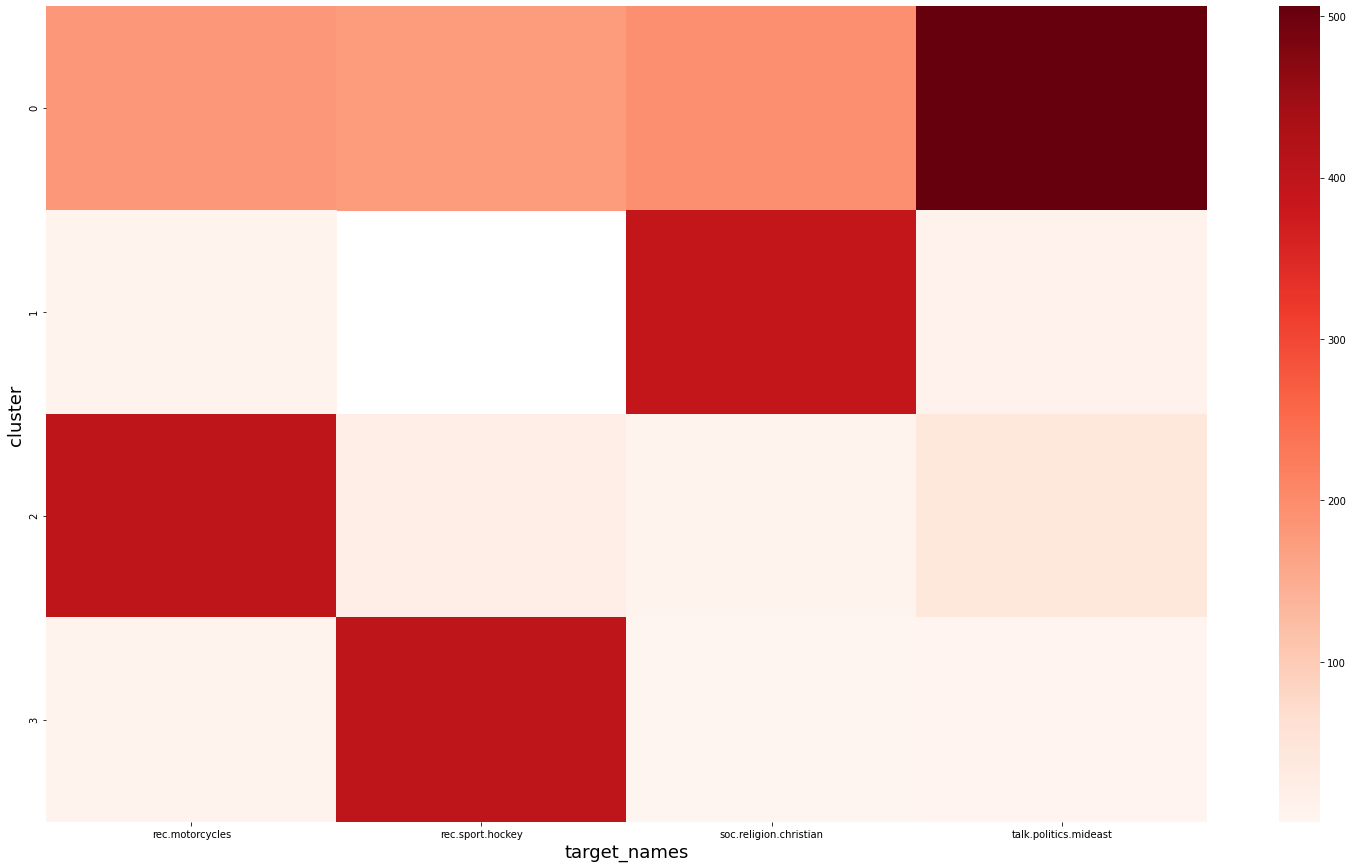

In [12]:
fig, ax1 = plt.subplots(figsize=(26,15))
heatmap(clusters.unstack(level='target_names'), ax=ax1, cmap='Reds')
ax1.set_xlabel('target_names').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

We get the predominant target names for each of the clusters, which we can confirm by looking at the heatmap above. 

In [13]:
cluster_topics = data[['cluster', 'target_names', 'target']].groupby(['cluster', 'target_names']).count().sort_values('target').groupby(level=0).tail(1).reset_index()
cluster_topics

,cluster,target_names,target
0,1,soc.religion.christian,394
1,2,rec.motorcycles,401
2,3,rec.sport.hockey,403
3,0,talk.politics.mideast,506


Now we map each of the cluster labels to its initial target value according to the assigned target name. We print the mapping to make sure it is matching the labels correctly.

In [14]:
target_mapping = {}

for i in range(cluster_topics.shape[0]):
  target_mapping[cluster_topics.iloc[i]['cluster']] = actual_targets[cluster_topics.iloc[i]['target_names']]

print(target_mapping)

{1: 15, 2: 8, 3: 10, 0: 17}


We now map the cluster labels to the actual target labels so we can see how the clustering performed against its real labels. For this, we print a classification report, where we can see that the clustering did not perform too badly. We mostly have f1-scores over 0.70, except for target 'talk.politics.mideast'.

In [15]:
data['pred'] = data['cluster'].apply(lambda target: target_mapping[target])

print(classification_report(data['target'], data['pred']))

              precision    recall  f1-score   support

           8       0.84      0.67      0.75       598
          10       0.97      0.67      0.79       600
          15       0.96      0.66      0.78       599
          17       0.48      0.90      0.62       564

    accuracy                           0.72      2361
   macro avg       0.81      0.72      0.74      2361
weighted avg       0.82      0.72      0.74      2361



## Part C: LDA Topic Modeling

In order to perform topic modeling, we first have to tokenize each of the documents. After we do this, we can create a dictionary with all the tokens, however, here we also filter the tokens that appear in less than 118 documents and in more than 95% of the documents. We then create a bag of words using the term document frequency for each document. We print the result for the first document, so we see what the transformation did. 

In [16]:
tokenized_documents = data['content'].apply(lambda document: document.split())

dictionary = corpora.Dictionary(tokenized_documents)
dictionary.filter_extremes(no_below=118, no_above=0.95)

corpus = [dictionary.doc2bow(document) for document in tokenized_documents]

print(corpus[0])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


Now we create the LDA (Latent Dirichlet Allocation) model to which we define a few parameters. We first give it our corpus, which is the bag of words we created in the previous step, we also define the number of topics we want it to find, we give it the dictinary we created from our documents, the chunksize, which is the number of documents it should use for each training chunk, the maximum number of iterations through the corpus when inferring the topic distribution and the number of passes through the corpus during training.

In [ ]:
lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, chunksize=10, iterations=100, passes=10)

We now show the topics that the model found with its 10 most representative words. By reading through these topics, we can already get an idea which one belongs to which target.

In [18]:
lda.show_topics()

[(0,
  '0.033*"team" + 0.029*"year" + 0.023*"game" + 0.022*"hockei" + 0.018*"time" + 0.017*"new" + 0.017*"plai" + 0.014*"armenian" + 0.013*"like" + 0.013*"wing"'),
 (1,
  '0.040*"god" + 0.031*"peopl" + 0.021*"christian" + 0.020*"believ" + 0.019*"know" + 0.018*"think" + 0.016*"reason" + 0.013*"evid" + 0.012*"jesu" + 0.011*"thing"'),
 (2,
  '0.141*"edu" + 0.098*"write" + 0.091*"articl" + 0.080*"com" + 0.055*"apr" + 0.042*"bike" + 0.025*"like" + 0.024*"new" + 0.020*"motorcycl" + 0.018*"ride"'),
 (3,
  '0.072*"israel" + 0.053*"isra" + 0.047*"state" + 0.041*"jew" + 0.034*"kill" + 0.033*"arab" + 0.030*"war" + 0.029*"right" + 0.028*"attack" + 0.027*"govern"')]

We now want to label our documents according to the topics that the model found. To do this, we give the corpus to the LDA model, which in return, gives for each document the probability to belong to each topic. So we get topic with the maximum probability and append it to our dataframe. We then print the its head to see how the topics look like.

In [19]:
topics = lda[corpus]

data['topics_lda'] = [max(topic, key=lambda item: item[1])[0] for topic in topics]

data.head()

,content,target,target_names,cluster,pred,topics_lda
10,recommend duc worth ducati gt line ducati gt m...,8,rec.motorcycles,2,8,2
21,nhl team captain articl apr samba oit unc edu ...,10,rec.sport.hockey,3,10,0
28,pantheism environment articl apr atho rutger e...,15,soc.religion.christian,1,15,1
33,isra expans lust articl spam math adelaid edu ...,17,talk.politics.mideast,0,17,3
35,goali mask articl netnew upenn edu kkeller mai...,10,rec.sport.hockey,0,17,0


Just like we did in the previous section, we group our data by cluster and target name, together with the group size, so we can understand how many different documents from different target names were put together in the same cluster. 

In [20]:
clusters = data.groupby(['topics_lda', 'target_names']).size()

We also plot a heatmap to visualize the information we got in the previous step, where we can see the predominant target name for each of the clusters through the darker colors. We can assume that the clustering did a decent job, since all target names are predominant in different clusters, although there is some overlap between certain topics.

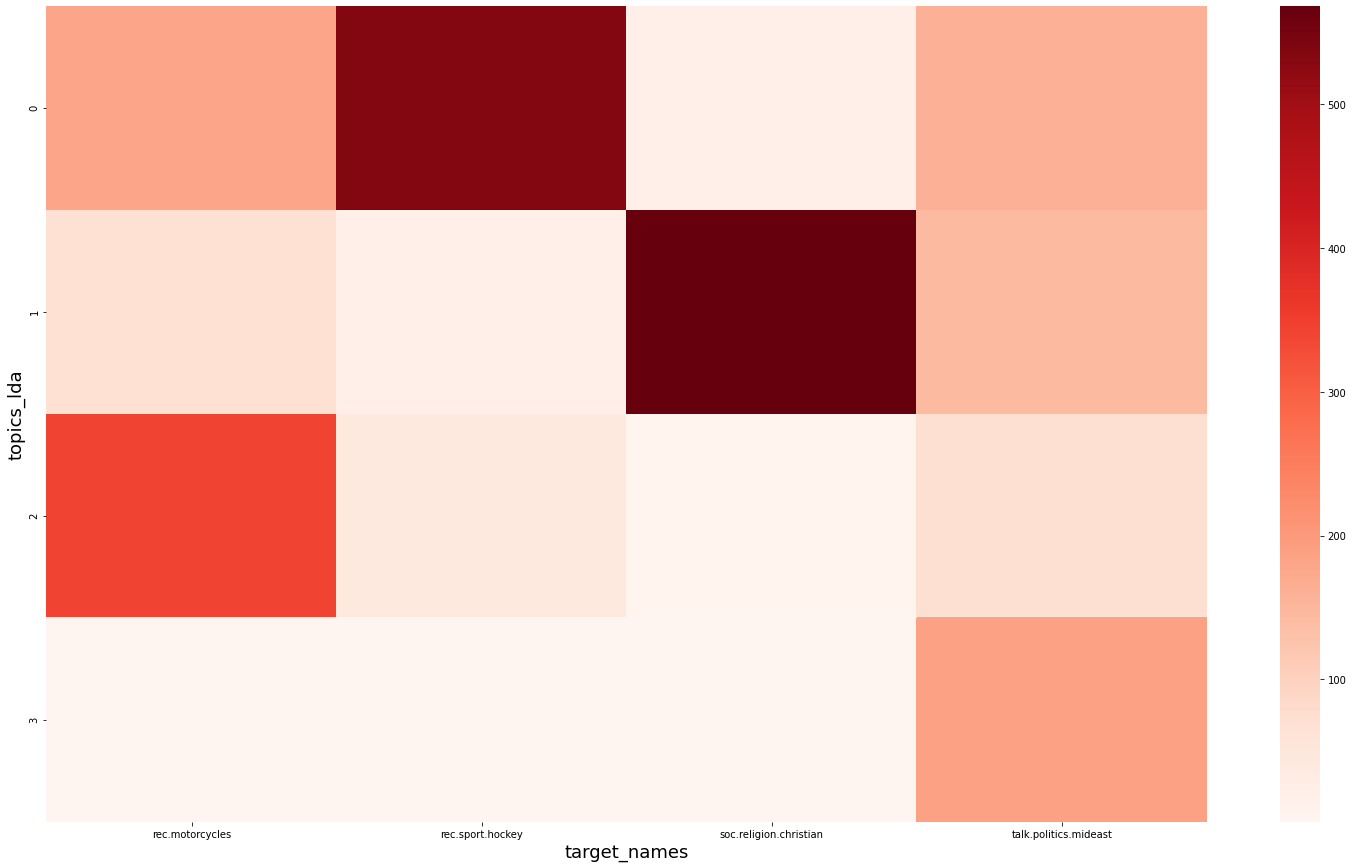

In [21]:
fig, ax1 = plt.subplots(figsize=(26,15))
heatmap(clusters.unstack(level='target_names'), ax=ax1, cmap='Reds')
ax1.set_xlabel('target_names').set_size(18)
ax1.set_ylabel('topics_lda').set_size(18)

We get the predominant target names for each of the clusters, which we can also confirm by looking at the heatmap above. 

In [22]:
cluster_topics = data[['topics_lda', 'target_names', 'target']].groupby(['topics_lda', 'target_names']).count().sort_values('target').groupby(level=0).tail(1).reset_index()
cluster_topics

,topics_lda,target_names,target
0,3,talk.politics.mideast,188
1,2,rec.motorcycles,344
2,0,rec.sport.hockey,535
3,1,soc.religion.christian,568


And now we map each of the cluster labels to its initial target value according to the assigned target name. We print the mapping to make sure it is matching the labels correctly.

In [23]:
target_mapping = {}

for i in range(cluster_topics.shape[0]):
  target_mapping[cluster_topics.iloc[i]['topics_lda']] = actual_targets[cluster_topics.iloc[i]['target_names']]

print(target_mapping)

{3: 17, 2: 8, 0: 10, 1: 15}


We now map the cluster labels to the actual target labels so we can see how the clustering performed against its real labels. For this, we print a classification report, where we can see that the topic modeling did not perform too badly again, but did perform worse than the KMeans clustering. 

In [24]:
data['pred_lda'] = data['topics_lda'].apply(lambda target: target_mapping[target])

print(classification_report(data['target'], data['pred_lda']))

              precision    recall  f1-score   support

           8       0.74      0.58      0.65       598
          10       0.59      0.89      0.71       600
          15       0.71      0.95      0.81       599
          17       0.97      0.33      0.50       564

    accuracy                           0.69      2361
   macro avg       0.75      0.69      0.67      2361
weighted avg       0.75      0.69      0.67      2361



Here we can visualize nicely how each topic is relates to each other in terms of distance and overlap, as well as the most representative terms on the right.

In [25]:
pyLDAvis.enable_notebook()

LDAvis_prepared = prepare(lda, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.168687 -0.064863       1        1  38.756008
0      0.216335 -0.078019       2        1  35.792460
3     -0.304630 -0.175290       3        1  12.743608
2     -0.080393  0.318172       4        1  12.707923, topic_info=         Term         Freq        Total Category  logprob  loglift
18        edu  2695.000000  2695.000000  Default  30.0000  30.0000
31      write  2111.000000  2111.000000  Default  29.0000  29.0000
13     articl  1664.000000  1664.000000  Default  28.0000  28.0000
127       com  1270.000000  1270.000000  Default  27.0000  27.0000
79     israel  1146.000000  1146.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
10      think   202.322994  1469.465092   Topic4  -4.3582   0.0802
132       let   124.174968   567.852679   Topic4  -4.8464   0.5428
135     right   149.934978   939.492309   Topic4  -4.6579   0.2278
90   question   127.145104   644.721537   Topic4  -4.8228   0.4395
11       want   110.467675   758.067918   Topic4  -4.9634   0.1369

[200 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
32        1  0.995220    accept
313       1  0.312861    action
313       3  0.683481    action
200       3  0.998363  american
152       1  0.996532    answer
...     ...       ...       ...
31        4  0.731690     write
143       1  0.465218     wrote
143       2  0.063853     wrote
143       4  0.469779     wrote
113       2  0.999541      year

[262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])